## Trend filtering after spatial denoising

In [39]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from trendFiltering.trendfilter import TF, TFsafe

### code of L1-TF
http://www.cvxpy.org/en/1.0/examples/applications/l1_trend_filter.html

In [41]:
import cvxpy as cvx
import cvxopt as cvxopt

def L1TF_D2(y, vlambda=50):
    n = y.size
    # Form second difference matrix.
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
#     D_coo = D.tocoo()
#     D = cvxopt.spmatrix(D_coo.data, D_coo.row.tolist(), D_coo.col.tolist())

    # Solve l1 trend filtering problem.
    x = cvx.Variable(rows=n)
    obj = cvx.Minimize(0.5 * cvx.sum_squares(y - x)
                       + vlambda * cvx.norm(D*x, 1) )
    prob = cvx.Problem(obj)
    # ECOS and SCS solvers fail to converge before
    # the iteration limit. Use CVXOPT instead.
    prob.solve(solver=cvx.CVXOPT,verbose=True)

    print('Solver status: %s'%(prob.status))
    # Check for error.
    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")
    return x.value

In [86]:
def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n).todense()
    return np.linalg.norm(np.dot(np.linalg.pinv(D.T), y), ord=np.inf)

In [88]:
print(lambda_max_D2(y))
print(y.var()*y.size)

71965.3435509573
40590.05118966299


### Simulated data

In [42]:
xp = np.array([1, 100, 150, 260, 300, 350, 400], dtype='float64')
yp = np.array([3, 10, -2, -5, 9, 2, 6], dtype='float64')
x = np.linspace(1, 400, num=400)
spl = sp.interpolate.splrep(xp, yp)
y = sp.interpolate.splev(x, spl)
y = y + np.random.normal(size = y.shape)*5

---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  1.03e+05   242  9.29e+03   125   150   123
   2  9.51e+03   167  6.14e+02    64   260    74
   3  9.23e+03   118  4.98e+02    59   249    90
   4  4.93e+03   103  2.53e+02    47   287    64
   5  4.76e+03    78  2.48e+02    43   296    59
   6  2.88e+03    92  1.99e+02    35   306    57
   7  3.67e+03    88  2.32e+02    62   290    46
   8  4.68e+03    73  2.27e+02    72   288    38
   9  2.85e+03    53  1.26e+02    50   301    47
  10  1.87e+03    64  9.17e+01    34   314    50
  11  3.49e+03    29  1.57e+02    38   300    60
  12  1.52e+03    36  7.04e+01    34   319    45
  13  2.48e+03    26  9.94e+01    32   313    53
  14  1.29e+03    18  4.49e+01    34   315    49
  15  1.13e+03    14  2.96e+01    37   319    42
  16  8.80e+02    13  2.00e+01    34   327    37
  17  1.39e+03    16  4.91e+01    31   330    37
  18  9.62e+02

  99  1.80e+04    50  1.84e+02    30   323    45
 100  1.26e+04    36  1.24e+02    20   337    41
 101  5.14e+03    37  4.85e+01    19   351    28
 102  3.47e+03    19  3.13e+01    15   354    29
 103  1.96e+03    11  1.60e+01    14   361    23
 104  4.18e+02    30  3.43e+00    11   372    15
 105  1.57e+04    20  1.53e+02    14   350    34
 106  2.14e+03    10  1.80e+01    11   362    25
 107  5.99e+02     9  2.53e+00    11   368    19
 108  1.21e+03    10  8.70e+00    11   367    20
 109  8.82e+02    17  8.49e+00    11   371    16
 110  5.15e+03    29  5.70e+01    17   362    19
 111  1.29e+04    15  1.26e+02    33   349    16
 112  2.11e+03    15  1.85e+01    21   364    13
safeguard invoked
 113  2.11e+03    14  1.84e+01    21   365    12
safeguard invoked
 114  1.66e+03    32  2.23e+01    20   366    12
safeguard invoked
 115  1.66e+03    31  2.20e+01    20   365    13
safeguard invoked
 116  1.86e+03    30  1.91e+01    20   364    14
safeguard invoked
 117  1.66e+03    30  2.06e+

  62  6.41e+04    57  3.20e+02    64   297    37
safeguard invoked
  63  6.40e+04    56  3.20e+02    64   298    36
safeguard invoked
  64  6.40e+04    55  3.20e+02    65   297    36
safeguard invoked
  65  6.35e+04    56  3.17e+02    64   298    36
safeguard invoked
  66  6.34e+04    55  3.17e+02    63   299    36
safeguard invoked
  67  6.30e+04    64  3.16e+02    62   300    36
safeguard invoked
  68  6.30e+04    64  3.16e+02    62   299    37
safeguard invoked
  69  6.30e+04    63  3.16e+02    62   300    36
safeguard invoked
  70  6.30e+04    62  3.16e+02    63   299    36
safeguard invoked
  71  6.33e+04    67  3.17e+02    64   298    36
safeguard invoked
  72  6.33e+04    66  3.17e+02    65   297    36
safeguard invoked
  73  6.42e+04    65  3.22e+02    66   296    36
safeguard invoked
  74  6.42e+04    64  3.22e+02    66   297    35
safeguard invoked
  75  6.34e+04    70  3.18e+02    65   298    35
safeguard invoked
  76  6.34e+04    69  3.18e+02    65   297    36
safeguard inv

 192  6.62e+04    59  3.31e+02    65   297    36
safeguard invoked
 193  6.62e+04    58  3.31e+02    65   296    37
safeguard invoked
 194  6.39e+04    63  3.20e+02    64   297    37
safeguard invoked
 195  6.39e+04    62  3.19e+02    64   298    36
safeguard invoked
 196  6.39e+04    60  3.19e+02    65   297    36
safeguard invoked
 197  6.43e+04    60  3.22e+02    66   296    36
safeguard invoked
 198  6.43e+04    59  3.22e+02    66   297    35
safeguard invoked
 199  6.39e+04    63  3.20e+02    65   298    35
safeguard invoked
 200  6.39e+04    62  3.20e+02    65   297    36
safeguard invoked
 201  6.45e+04    60  3.22e+02    65   296    37
safeguard invoked
 202  6.49e+04    59  3.25e+02    65   295    38
safeguard invoked
 203  6.42e+04    59  3.21e+02    65   296    37
safeguard invoked
 204  6.39e+04    60  3.20e+02    65   297    36
safeguard invoked
 205  6.42e+04    59  3.21e+02    65   296    37
safeguard invoked
 206  6.39e+04    58  3.19e+02    65   297    36
safeguard inv

 322  3.64e+04    43  1.82e+02    39   323    36
safeguard invoked
 323  3.63e+04    42  1.82e+02    38   324    36
safeguard invoked
 324  3.54e+04    45  1.77e+02    37   325    36
safeguard invoked
 325  3.55e+04    43  1.77e+02    38   324    36
safeguard invoked
 326  3.54e+04    43  1.77e+02    37   325    36
safeguard invoked
 327  3.53e+04    42  1.77e+02    36   326    36
safeguard invoked
 328  3.55e+04    41  1.77e+02    37   325    36
safeguard invoked
 329  3.53e+04    40  1.77e+02    36   326    36
safeguard invoked
 330  3.55e+04    40  1.78e+02    37   325    36
safeguard invoked
 331  3.53e+04    39  1.76e+02    36   326    36
safeguard invoked
 332  3.45e+04    40  1.72e+02    35   327    36
safeguard invoked
 333  3.46e+04    39  1.73e+02    34   328    36
safeguard invoked
 334  3.21e+04    40  1.61e+02    33   329    36
safeguard invoked
 335  3.21e+04    39  1.61e+02    34   328    36
safeguard invoked
 336  3.27e+04    40  1.63e+02    35   327    36
safeguard inv

 447  1.59e+04    37  7.81e+01    20   342    36
safeguard invoked
 448  1.60e+04    37  7.86e+01    21   341    36
safeguard invoked
 449  1.59e+04    36  7.83e+01    20   342    36
safeguard invoked
 450  1.70e+04    39  8.35e+01    21   341    36
safeguard invoked
 451  1.70e+04    38  8.35e+01    22   340    36
safeguard invoked
 452  1.70e+04    37  8.37e+01    23   339    36
safeguard invoked
 453  1.80e+04    38  8.86e+01    24   338    36
safeguard invoked
 454  1.80e+04    37  8.86e+01    23   339    36
safeguard invoked
 455  1.73e+04    37  8.47e+01    22   340    36
safeguard invoked
 456  1.73e+04    37  8.49e+01    23   339    36
safeguard invoked
 457  1.73e+04    36  8.47e+01    22   340    36
safeguard invoked
 458  1.64e+04    36  8.06e+01    21   341    36
safeguard invoked
 459  1.62e+04    35  7.95e+01    20   342    36
safeguard invoked
 460  1.84e+04    35  9.05e+01    21   341    36
safeguard invoked
 461  1.71e+04    34  8.41e+01    20   342    36
safeguard inv

 595  4.37e+03    25  2.05e+01    25   362    11
safeguard invoked
 596  4.33e+03    24  2.04e+01    25   363    10
safeguard invoked
 597  4.36e+03    25  2.05e+01    25   362    11
safeguard invoked
 598  4.36e+03    24  2.05e+01    25   361    12
safeguard invoked
 599  4.34e+03    24  2.05e+01    25   362    11
safeguard invoked
 600  4.34e+03    23  2.04e+01    25   363    10
safeguard invoked
 601  4.07e+03    31  2.07e+01    25   364     9
safeguard invoked
 602  4.10e+03    29  2.08e+01    25   363    10
safeguard invoked
 603  4.13e+03    29  2.10e+01    25   362    11
safeguard invoked
 604  4.09e+03    28  2.08e+01    25   363    10
safeguard invoked
 605  4.07e+03    29  2.06e+01    25   364     9
safeguard invoked
 606  4.13e+03    28  2.10e+01    25   363    10
safeguard invoked
 607  4.08e+03    28  2.07e+01    25   364     9
safeguard invoked
 608  4.07e+03    28  2.08e+01    25   365     8
safeguard invoked
 609  4.07e+03    27  2.08e+01    25   366     7
safeguard inv

 727  4.24e+03    17  1.94e+01    25   364     9
safeguard invoked
 728  4.06e+03    16  1.85e+01    25   365     8
safeguard invoked
 729  4.00e+03    16  1.82e+01    24   366     8
safeguard invoked
 730  3.99e+03    16  1.82e+01    24   365     9
safeguard invoked
 731  3.99e+03    15  1.82e+01    24   366     8
safeguard invoked
 732  3.98e+03    22  1.82e+01    23   367     8
safeguard invoked
 733  3.96e+03    21  1.82e+01    23   366     9
safeguard invoked
 734  4.21e+03    19  1.94e+01    23   365    10
safeguard invoked
 735  4.20e+03    18  1.94e+01    23   366     9
safeguard invoked
 736  4.28e+03    17  1.96e+01    23   365    10
safeguard invoked
 737  4.41e+03    17  2.03e+01    23   364    11
safeguard invoked
 738  4.30e+03    16  1.97e+01    23   365    10
safeguard invoked
 739  5.43e+03    19  2.54e+01    23   364    11
safeguard invoked
 740  5.43e+03    18  2.53e+01    23   363    12
safeguard invoked
 741  5.52e+03    17  2.58e+01    23   362    13
safeguard inv

 859  1.97e+03    13  8.18e+00    12   377     9
safeguard invoked
 860  1.58e+03    13  6.43e+00    11   378     9
safeguard invoked
 861  1.61e+03    12  6.55e+00    12   377     9
safeguard invoked
 862  3.13e+03     9  1.38e+01    13   376     9
safeguard invoked
 863  3.13e+03     8  1.39e+01    14   375     9
safeguard invoked
 864  2.54e+03     8  1.09e+01    13   376     9
safeguard invoked
 865  1.76e+03    11  7.12e+00    12   377     9
safeguard invoked
 866  1.76e+03    10  7.12e+00    12   376    10
safeguard invoked
 867  2.18e+03     9  9.10e+00    13   375    10
safeguard invoked
 868  1.95e+03     9  7.95e+00    12   376    10
safeguard invoked
 869  2.10e+03     9  8.75e+00    13   375    10
safeguard invoked
 870  2.10e+03     8  8.75e+00    13   376     9
safeguard invoked
 871  2.04e+03     7  8.48e+00    12   377     9
safeguard invoked
 872  6.56e+02    24  2.82e+00    11   378     9
safeguard invoked
 873  6.42e+02    23  2.82e+00    11   377    10
safeguard inv

 995  1.96e+03    28  1.13e+01    14   373    11
safeguard invoked
 996  1.93e+03    27  1.12e+01    14   374    10
safeguard invoked
 997  2.72e+03    27  1.42e+01    15   373    10
safeguard invoked
 998  1.97e+03    26  1.10e+01    14   374    10
safeguard invoked
 999  3.36e+03    25  1.66e+01    15   373    10
safeguard invoked
1000  4.05e+03    25  2.00e+01    16   372    10
safeguard invoked


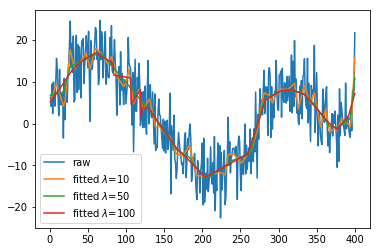

In [43]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [10, 50, 100]:
    prob = TFsafe(y[:,np.newaxis],lam,order=2,mode = -1)
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  6e+05  9e+00  2e-01  1e+00
 1:  5.2581e+02  5.4002e+02  6e+05  9e+00  2e-01  2e+01
 2: -1.5801e+02  1.4100e+01  6e+05  8e+00  2e-01  2e+02
 3: -5.6829e+01  4.6192e+01  2e+05  4e+00  8e-02  1e+02
 4:  6.6773e+02  7.7876e+02  2e+05  4e+00  9e-02  1e+02
 5:  3.0728e+02  4.0258e+02  9e+04  1e+00  3e-02  1e+02
 6:  1.3320e+03  1.4206e+03  8e+04  1e+00  3e-02  9e+01
 7:  1.2280e+03  1.2637e+03  3e+04  5e-01  1e-02  4e+01
 8:  2.4481e+03  2.4870e+03  3e+04  5e-01  1e-02  4e+01
 9:  2.1121e+03  2.1329e+03  2e+04  3e-01  6e-03  2e+01
10:  3.4479e+03  3.4600e+03  1e+04  1e-01  3e-03  1e+01
11:  3.5546e+03  3.5605e+03  5e+03  7e-02  2e-03  6e+00
12:  4.3996e+03  4.4076e+03  7e+03  8e-02  2e-03  8e+00
13:  4.2870e+03  4.2904e+03  3e+03  4e-02  8e-04  3e+00
14:  4.6378e+03  4.6387e+03  8e+02  9e-03  2e-04  9e-01
15:  4.7219e+03  4.7222e+03  2e+02  3e-03  6e-05  3e-01
16:  4.7451e+03  4.7451e+03  8e+01  8e-04  2e-05  

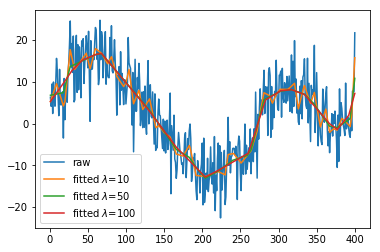

In [44]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [10, 50, 100]:
    prob = L1TF_D2(y[:,np.newaxis],lam)
    plt.plot(x, prob, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()

### Load TK's data

In [48]:
cropSDN = sp.io.loadmat('cropSDN.mat')['cropSDN'][0]

---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  5.43e+04  1310  1.06e+04   684   679   637
   2  2.37e+03   800  9.12e+02   165  1697   138
   3  4.61e+03   696  7.64e+02   454  1297   249
   4  3.66e+03   469  4.65e+02   376  1315   309
   5  2.24e+03   224  1.63e+02   261  1466   273
   6  1.05e+03   109  4.02e+01   180  1644   176
   7  8.87e+02    33  1.63e+01   144  1693   163
   8  7.77e+02    13  4.83e+00   137  1720   143
   9  7.38e+02     5  9.48e-01   134  1731   135
  10  7.30e+02     1  1.10e-02   133  1734   133
  11  7.30e+02     0  0.00e+00   133  1733   134
---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  2.13e+05  1329  2.10e+04   644   680   676
   2  9.16e+03   634  9.49e+02   173  1639   188
   3  6.19e+03   693  8.03e+02   162  1551   287
   4  8.

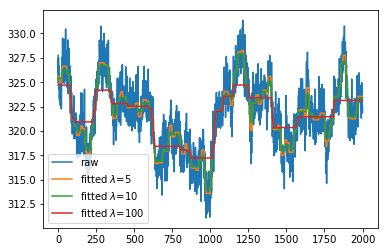

In [54]:
x = np.arange(cropSDN.shape[0])
plt.plot(x, cropSDN, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TFsafe(cropSDN[:,np.newaxis],lam,order=1,mode = -1)
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()